In [25]:
import matplotlib.pyplot as plt
from dolfin import *

In [30]:
# Create mesh and define function space
nx = ny = nz = 32
mesh = UnitSquareMesh(nx,ny)
P1 = FiniteElement('P', triangle, 1)
V1 = VectorElement('P', triangle, 1)
# element  = P1*P1*P1*P1*V1*V1
"""
The function space is : \rho_1,\rho_2,\phi,T,u_1,u_2

"""
element = MixedElement([P1, P1, P1, P1 , V1, V1])
V = FunctionSpace(mesh, element)
VV = FunctionSpace(mesh,P1)
VVV = FunctionSpace(mesh,V1)
#v_1, v_2, v_3 , v_4 , v_5 ,v_6= TestFunctions(V)

v_1 = TestFunction(VV)
v_2 = TestFunction(VV)
v_3 = TestFunction(VV)
v_4 = TestFunction(VV)
v_5 = TestFunction(VVV)
v_6 = TestFunction(VVV)

#u = Function(V)
#u_1, u_2, u_3, u_4, u_5, u_6 = split(u)


u_1 = Function(VV)
u_2 = Function(VV)
u_3 = TrialFunction(VV)
u_4 = Function(VV)


# time step
dt = 0.01 
delta = 0.5
Cv = 1
z = 1
e = 1
mu_1 = Constant(1.334)
mu_2 = Constant(2.032)
kB = 1
epsilon = 10
k = 1
q_1 = 1
q_2= -1

num_steps = 100
tol = 1E-14

# define the dirichlet boundary for \phi

phi_L = Constant(100)
def boundary_L(x, on_boundary):

    return on_boundary and near(x[0], 0, tol)

bc_L = DirichletBC(VV, phi_L, boundary_L)


phi_R = Constant(0)
def boundary_R(x, on_boundary):

    return on_boundary and near(x[0], 1, tol)

bc_R = DirichletBC(VV, phi_R, boundary_R)

bcs = [bc_L, bc_R]

'''
later on when solving:

solve(a == L, u, bcs)
'''
def boundary_rho(x,on_boundary):
    return on_boundary and (near(x[0],0,tol) or near(x[0],1,tol))

rho_bc = Constant(-1)
T_bc = Constant(0)
bc_rho = DirichletBC(VV,rho_bc,boundary_rho)
bc_T = DirichletBC(VV,T_bc,boundary_rho)


0.01


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2017.2.0
*** Git changeset:  4c59bbdb45b95db2f07f4e3fd8985c098615527f
*** -------------------------------------------------------------------------


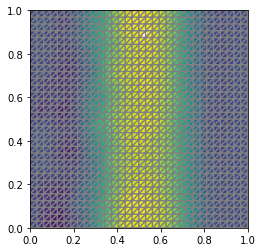

In [31]:
# project the initial condition

# Initial condition for temperature and species are all set to constant
rho_1_0 = Constant(-1)
rho_2_0 = Constant(-1)
T_0 = Constant(0)

class InitialCondition(Expression):
    def eval_cell(self, value, x, ufc_cell):
        #if x[0] <= 1.0:
        #   value[0] = 1.0
        #else:
        value[0] = 16*sin(x[0]*4)*cos(x[1]*4)+20

class tempInitialCondition(Expression):

    def eval_cell(self, value, x, ufc_cell):
        value[0] = x[0]**2-x[1]**2+10


u_n_4 = project(T_0,VV)
#u_n_4 = Function(VV)
#u_n_4.interpolate(tempInitialCondition())
phi_n = project(phi_L,VV)
u_n_1 = project(rho_1_0,VV)
#u_n_1.interpolate(InitialCondition())
u_n_2 = project(rho_2_0,VV)
#U_n_2.interpolate(InitialCondition())


# Create VTK files for visualization output
vtkfile_u_1 = File('reaction_system/u_1.pvd')


# Create progress bar
progress = Progress('Time-stepping')
set_log_level(PROGRESS)

T = 1
t = 0.0
for n in range(num_steps):
    t +=dt
    
    # First solve the poisson equation
    
    # \phi equation
    '''
    F_phi = epsilon*inner(nabla_grad(u_3),nabla_grad(v_3))*dx-q_1*exp(u_n_1)*v_3*dx-q_2*exp(u_n_2)*v_3*dx
    #solve(F_phi == 0, u_3, bcs)
    a_phi,L_phi = lhs(F_phi),rhs(F_phi)
    u_3 = Function(VV)
    solve(a_phi==L_phi,u_3,bcs)
    plot(u_3)
    plot(mesh)
    plt.show()
    print u_3.vector().max(),u_3.vector().min()
    phi_n.assign(u_3)
    '''
    u = TrialFunction(VV)
    v = TestFunction(VV)

    F  = epsilon*inner(nabla_grad(u), nabla_grad(v))*dx-q_1*exp(u_n_1)*v*dx-q_2*exp(u_n_2)*v*dx
    a,L = lhs(F),rhs(F)
    # Compute solution
    u = Function(VV)
    solve(a == L, u, bcs)
    # Plot solution and mesh
    
    phi_n.assign(u)
    
    # Then the continuity equations
    
    # \rho_1 equation
    #F_rho_1 = (1/dt)*exp(u_1)*v_1*dx-(1/dt)*exp(u_n_1)*v_1*dx+mu_1*dot(grad(exp(u_1+u_n_4)+q_1*phi_n),grad(v_1))*dx# not sure whether grad() can take this input
    F_rho_1 = (exp(u_1)*exp(u_n_4)*dot(grad(u_1),grad(v_1))+exp(u_1)*exp(u_n_4)*dot(grad(u_n_4),grad(v_1))+q_1*dot(grad(phi_n),grad(v_1)))*dx-(1/dt)*exp(u_n_1)*v_1*dx+(1/dt)*exp(u_1)*v_1*dx
    solve(F_rho_1==0,u_1,bc_rho)
    
    
    #F_rho_2 = -(1/dt)*(exp(u_n_2)-exp(u_2))*v_2*dx+exp(u_2)*exp(u_n_4)*dot(grad(u_2),grad(v_2))*dx+exp(u_2)*exp(u_n_4)*inner(grad(u_n_4),grad(v_2))*dx+q_1*dot(grad(phi_n),grad(v_2))*dx
    F_rho_2 = (exp(u_2)*exp(u_n_4)*dot(grad(u_2),grad(v_2))+exp(u_2)*exp(u_n_4)*dot(grad(u_n_4),grad(v_2))+q_2*dot(grad(phi_n),grad(v_2)))*dx-(1/dt)*exp(u_n_2)*v_2*dx+(1/dt)*exp(u_2)*v_2*dx
    solve(F_rho_2==0,u_2,bc_rho)
    
    # project the velocities
    u_n_5 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_1)*exp(u_n_4)+q_1*e*nabla_grad(phi_n))*mu_1,VVV) # velocity for species 1
    u_n_6 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_2)*exp(u_n_4)+q_2*e*nabla_grad(phi_n))*mu_2 ,VVV) # velocity for species 2
    
    plot(u_2)
    plot(mesh)
    print t
    # Temperature equation
    
    F_T = (1/dt)*kB*(exp(u_1)+exp(u_2))*exp(u_4)*v_4*dx-(1/dt)*kB*(exp(u_n_1)+exp(u_n_2))*exp(u_n_4)*v_4*dx \
          -kB*exp(u_4)*dot(u_n_5,grad(u_n_1))*v_4*dx- kB*exp(u_4)*dot(u_n_5,grad(v_4))*u_n_1*dx \
        -kB*exp(u_4)*dot(u_n_6,grad(u_n_1))*v_4*dx- kB*exp(u_4)*dot(u_n_6,grad(v_4))*u_n_1*dx+ \
          k*exp(u_4)*dot(grad(u_4),grad(v_4))*dx-(mu_1*exp(u_n_1)*dot(u_n_5,u_n_5)+mu_2*exp(u_n_2)*dot(u_n_6,u_n_6))*v_4*dx 
    
    #F_T = (k*exp(u_4)*dot(grad(u_4),grad(v_4)))*dx-(exp(u_n_1)*dot(u_n_5,u_n_5)+exp(u_n_2)*dot(u_n_6,u_n_6))*v_4*dx
    solve(F_T==0,u_4,bc_T)
    # update the values
    u_n_1.assign(u_1)
    u_n_2.assign(u_2)
    u_n_4.assign(u_4)
    
    # Save solution to file (VTK)
    vtkfile_u_1 << (u_1, t)
    # Update progress bar
    progress.update(t/T)
    
    #plot(phi_n)
    #plt.show()

#interactive()

In [300]:
u_n_5 = project((exp(u_n_4)*nabla_grad(u_n_4)+nabla_grad(u_1)*exp(u_n_4)+q_1*e*nabla_grad(phi_n))*mu_1,VVV)
print u_n_6.vector().max()


F_T = exp(u_4)*dot(grad(u_4),grad(v_4))*dx+exp(u_n_1)*dot(u_n_5,u_n_5)*v_4*dx

solve(F_T==0,u_4,bc_T)

plot(u_4)
plot(mesh)

0.0


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2017.2.0
*** Git changeset:  4c59bbdb45b95db2f07f4e3fd8985c098615527f
*** -------------------------------------------------------------------------
